# Projet SD-WAN-ReinforcementLearning

# Partie: Recherche opérationnelle

In [ ]:
#!pip install pulp

Imports

In [1]:
import networkx as nx
import pulp
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

np.random.seed(1)

### Generation of random graph

In [2]:
def image_nertworkx(nodes = 25, edges = 4):
    g = nx.to_directed(nx.fast_gnp_random_graph(nodes,edges/nodes,directed=True))

    check_list = []
    for i, j in g.edges:
        if i not in check_list:
            check_list.append(i)
    for ii in range(nodes):
        if ii not in check_list:
            g = image_nertworkx(nodes , edges)
    return g

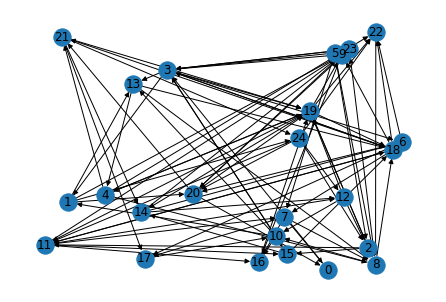

In [3]:
g = image_nertworkx()

node_pose = {}
for i in g.nodes():
    node_pose[i] = (random.uniform(1.0, 10.0),random.uniform(1.0, 10.0))

nx.draw(g,pos = node_pose, with_labels=True)
#plt.savefig("images/original.jpg")
plt.show()

### Generation of random attributes for the graph edges

In [4]:
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
    
nx.set_edge_attributes(g, color, 'color')

In [5]:
dict_capa = {}
for i, j in g.edges:
    dict_capa[i, j] = dict_capa[j, i] = round(random.uniform(50.0, 200.0), 0)

nx.set_edge_attributes(g, dict_capa, 'capacity')

In [6]:
dict_used = {}
for i, j in g.edges:
    dict_used[i, j] = dict_used[j, i] = dict_capa[i, j]-round(random.uniform(40.0, dict_capa[i, j]), 0)
    
nx.set_edge_attributes(g, dict_used, 'used')

In [7]:
# instantiate
list_keys = ['shortest_path','min_banwidth_sum']
nodes_models = {}

dict_res = defaultdict(dict)

In [8]:
source = 0
target = 24

In [9]:
Used_df = pd.DataFrame(np.zeros((1,1)))
for link in g.edges:
    s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
    Used_df[s_link] = g.edges[link]['used']
Used_df

,0,0_3,1_9,1_13,1_20,1_24,2_11,2_15,3_1,3_6,...,21_24,22_8,23_3,23_9,23_20,24_2,24_11,24_12,24_20,24_22
0,0.0,46.0,35.0,80.0,18.0,50.0,12.0,12.0,104.0,6.0,...,74.0,25.0,50.0,31.0,10.0,36.0,4.0,42.0,33.0,109.0


In [10]:
def new_iter_used(Used_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Used_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-2000,2000)/100
        else:
            random_value = bdw
            
        new_value = Used_df.iloc[-1,Used_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > g.edges[link]['capacity'] :
            new_value = g.edges[link]['capacity']

        New_iter[s_link] = new_value
    #print(New_iter.head())
    New_iter.iloc[-1,0] = iter
    Used_df = Used_df.append(New_iter)
    return Used_df


In [11]:
def update_list_df(Used_df):
    list_used_df = []

    for i in g.nodes:
        df = pd.DataFrame()
        for j in Used_df.keys():
            if str(j).split('_')[0] == str(i):
                if len(str(j).split('_')) == 2:
                    df[str(j).split('_')[1]] = Used_df.iloc[:,Used_df.columns.get_loc(j)]
                
        df['Time'] = Used_df.iloc[:,0]
        list_used_df.append(df)
    return list_used_df

In [12]:
## MARL Part

In [13]:
def init_colors():
    color = {}
    for i, j in g.edges:
        color[i, j] = color[j, i] = (0,0,0,0.5)

    nx.set_edge_attributes(g, color, 'color')

In [14]:
def get_path_as_list_tuples(path):
    solve_var = [] 
    for i in path.split("_"):
        var = str(i).split('(')
        var = var[1].split(',')
        var[0] = int(var[0])
        var[1] = int(var[1].strip(')'))
        solve_var.append(tuple(var))
    return solve_var

In [15]:
def plot_graph(attributes):
    x = []
    y = []
    for i in range(iter_):
        x.append(dict_res[i][attributes])
        y.append(i)

    p = plt.plot(y, x)

    plt.show(p)
    plt.close()

In [16]:
def draw_path(solve_var):
        for link in g.edges:
            if link in solve_var:
                g.edges[link[0],link[1]]['color'] = (1,0,0,1) 
    
        colors = nx.get_edge_attributes(g,'color').values()

        nx.draw(g, pos = node_pose, 
            edge_color=colors, 
            with_labels=True)
        ## Save chosen path ##
        plt.show()
        #plt.savefig("imgs/Q_table/Q_table_iter_{}".format(iter))
        plt.close()
        init_colors()

In [17]:
def get_possible_actions(current_node):
    sub_list = []
    for (i,j) in g.edges:
        if i == current_node:
            sub_list.append((i,j))
    return sub_list

In [18]:
def get_list_possibles_nodes(current_node):
    sub_list = get_possible_actions(current_node)
    nodes_list = []
    for (i,j) in sub_list:
        nodes_list.append(j)
    #print(nodes_list)
    return nodes_list

In [19]:
def new_iter_used(Used_df,action_taken, bdw):
    New_iter = pd.DataFrame(np.zeros((1,1)))
    iter = Used_df.iloc[-1,0]+1
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        action_taken = str(action_taken).strip('(').strip(')').replace(',','_').replace(' ','')
        if action_taken != s_link:
            random_value = np.random.randint(-2000,2000)/100
            
        else:
            random_value = bdw
            
        new_value = Used_df.iloc[-1,Used_df.columns.get_loc(s_link)] + random_value
        
        if new_value < 0 :
            new_value = 0
        elif new_value > g.edges[link]['capacity'] :
            new_value = g.edges[link]['capacity']

        New_iter[s_link] = new_value
    New_iter.iloc[-1,0] = iter
    Used_df = Used_df.append(New_iter)
    return Used_df

In [20]:
def get_epsilon():
    return (1.00 - iter_actuel / iter_ ) 

In [21]:
### MARL TRAINING

In [22]:
def scale(x, out_range=(0, 1)):
    if len(x[0,0]) == 1:
        return [1]
    else :
        domain = np.min(x), np.max(x)
        y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
        return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [23]:
from tensorflow.python.keras import Model, Sequential
from tensorflow.python.keras.layers import Dense,Dropout, LSTM
from tensorflow.keras.optimizers import Adam

from math import floor

/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/g13/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [24]:
dict_model = defaultdict(dict)
for i in g.nodes:
    cpt_output = 0
    
    #print("\n   Node : {}".format(i))
    
    for ii,j in g.edges:
        if (i == ii):
            #print("Edges Output : {}".format(j))
            dict_model[i][j] = g.edges[i, j]['used']
            cpt_output = cpt_output + 1
            
    dict_model[i]["cpt_output"] = cpt_output

In [25]:
def _build_compile_model(nodes_models,node):
    Used_df = pd.DataFrame(np.zeros((1,1)))
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        Used_df[s_link] = g.edges[link]['used']
    #Used_df= new_iter_Used(Used_df,-1, 0)

    list_model = update_list_df(Used_df)
    inputs = list_model[node]

    inputs = np.array(inputs).reshape(1, inputs.shape[1])
    inputs = np.append(inputs[0],target)
    inputs = np.array(inputs).reshape(1, inputs.shape[0])
    
    model = Sequential()

    model.add(LSTM(50, return_sequences = True, input_shape = (inputs.shape[0],inputs.shape[1])))
    model.add(Dropout(0.2))
    model.add(LSTM(25, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(Dense(10,activation='relu'))
    model.add(Dense(inputs.shape[1]-2,activation='softmax'))
    opt = Adam(learning_rate=0.05)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    nodes_models[node] = model
    return nodes_models
nodes_models = {}  
for i in range (25):
    nodes_models = _build_compile_model(nodes_models,i)
    #print(i)
    #print(nodes_models[i].summary())


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
def get_action(current_node):
    list_model = update_list_df(Used_df)
    
    inputs = list_model[current_node].iloc[-1,:]
    inputs = np.append(inputs,target)
    inputs = np.array(inputs).reshape(1,1, inputs.shape[0])
    expirience_replay[cpt] = inputs
 
    sub_list = get_possible_actions(current_node)
    
    if np.random.rand() <= get_epsilon(): #Epsilon
        return random.choice(sub_list)[1]
    else :
        return get_model_action(current_node,inputs)

In [27]:
def get_model_action(current_node,inputs):
    
    local_model = nodes_models[current_node]
    list_of_output = []
    for i in dict_model[current_node].keys():
        if i != 'cpt_output':
            list_of_output.append(i)

    pedicted_values = local_model.predict(inputs)
    #print(pedicted_values)
    
    value = np.argmax(pedicted_values[0])
    #print(pedicted_values[0])
    #print(value)
    return list_of_output[value]


In [28]:
def get_indx_from_value(current_node,value):
    list_values = []
    for i,j in g.edges:
        if (current_node == i):
            list_values.append(j)
            
    return list_values.index(value)

In [29]:
def give_final_reward(solve_var,neg_reward):
    for i in range(len(solve_var)) :
      
        action_taken = solve_var[i][1]
        current_node = solve_var[i][0]
      
        local_model = nodes_models[current_node]
        
        state = expirience_replay[i]
        target_model = local_model.predict(state)
      
        action_taken_id = get_indx_from_value(current_node,action_taken)
        #print(neg_reward)
        if len(solve_var) != max_move:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id] + (i+1)/neg_reward
         
        else:
            target_model[0,0,action_taken_id] = target_model[0,0,action_taken_id] - 0.5
        #print("\n")
        #print(local_model.predict(state))
        #print(scale(target_model))
        local_model.fit(state,scale(target_model),epochs=1,verbose=0)
        #print(local_model.predict(state))
        nodes_models[current_node] = local_model
            

In [30]:
def get_tuple_to_name(path):
    return(str(path).strip('(').strip(')').replace(',','_').replace(' ',''))


0 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


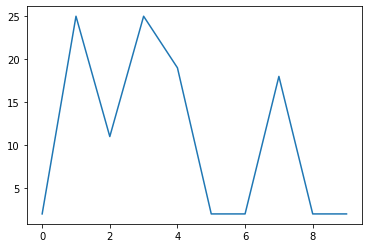

3 4


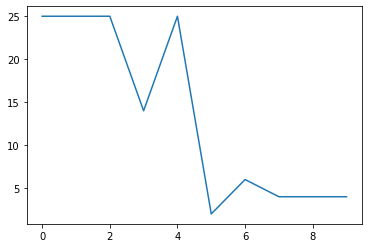

7 12


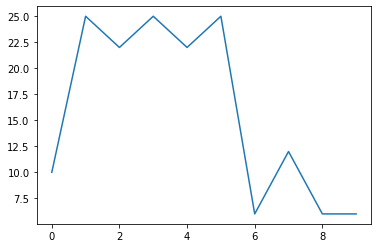

0 24


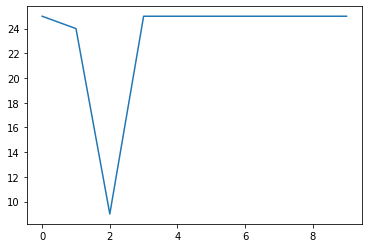

4 17


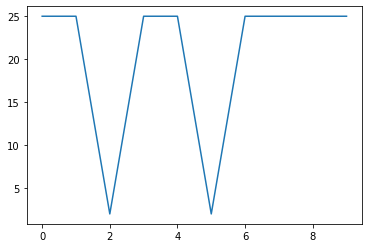

In [31]:
list_source_target = [(0,1),(3,4),(7,12),(0,24),(4,17)]
for iii in list_source_target:
    source = iii[0]
    target = iii[1]

    #print(source,target)

    if source != target :
        iter_ = 10
        iter_actuel = 0
        current_iter = 0
        var_dict = {}
        max_move = 25
        bdw = 20
        cpt = 0
        expirience_replay = {}
        
        summ = 0
        for ii in range(iter_):
            iter_actuel = ii + 1
            current_node = source
            path = ""
            cpt = 0
            solve_var = []
            j = source

            Used_df = pd.DataFrame(np.zeros((1,1)))
            for link in g.edges:
                s_link = get_tuple_to_name(link)
                Used_df[s_link] = g.edges[link]['used']

            flag_finished = False
            while flag_finished != True and cpt < max_move:
                j = get_action (current_node)
                i = current_node

                if ((i,j) in get_possible_actions(i)):
                    path += "{}_".format(str((i,j)))
                    solve_var.append((i,j))
                    var_dict[i,j] = 1
                    cpt = cpt +1
                    #print(Used_df.head())
                    if g.edges[i,j]['capacity'] > Used_df.iloc[-1,Used_df.columns.get_loc(get_tuple_to_name((i,j)))] + bdw:
                        #print("Yay")
                        Used_df = new_iter_used(Used_df,j,bdw)
                        current_node = j
                        if j == target:
                            flag_finished = True
                    else:
                        # print("fail")
                        Used_df = new_iter_used(Used_df,j,0)
            path_ = path[:-1]
            solve_var = get_path_as_list_tuples(path_)

            dict_res[ii]['nodes'] = len(solve_var)
            give_final_reward(solve_var,len(solve_var))
        plot_graph('nodes')
        

#plot_graph(summ/10)
#print("{} : {}".format(test,summ/10))


In [32]:
### TRAINING SARL ###

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
def get_state(solve_var,add_dim = True):
    state = np.zeros((25,25), np.int8)
    for (i,j) in g.edges:
        if (i,j) in solve_var:
            state[i,j] = 1
        elif i == source:
            state[i,j] = 2
        elif j == target:
            state[i,j] = 3
        else:
            state[i,j] = 0
    if add_dim:
        state = np.expand_dims(state, axis=0)
    #print(state)
        #print(state.shape)
    return state

In [35]:
def _build_compile_model_SARL():
    ### Inputs for Used Branch ###
    Used_df = pd.DataFrame(np.zeros((1,1)))
    for link in g.edges:
        s_link = str(link).strip('(').strip(')').replace(',','_').replace(' ','')
        Used_df[s_link] = g.edges[link]['used']

    list_model_SARL = Used_df.iloc[-1,:]
    input2 = np.array(list_model_SARL).reshape(1, list_model_SARL.shape[0])

    ### Used Branch ###
    Used_branch_Input = keras.Input(shape=(input2.shape))
    LSTM_50 = layers.LSTM(50, return_sequences = True)
    Used_branch = LSTM_50(Used_branch_Input)
    Dropout_1 = layers.Dropout(0.1)
    Used_branch = Dropout_1(Used_branch)
    LSTM_25 = layers.LSTM(25, return_sequences = True)
    Used_branch = LSTM_25(Used_branch)
    Dropout_2 = layers.Dropout(0.1)
    Used_branch = Dropout_2(Used_branch)
    Dense_10 = layers.Dense(10,activation='relu')
    Used_branch = Dense_10(Used_branch)
    Dense_outputs = layers.Dense(25,activation='sigmoid')(Used_branch)
    Reshape_layer_Used = layers.Reshape((1,25))
    Used_branch_Output = Reshape_layer_Used(Dense_outputs)

    ### Inputs for State Branch ###

    input1 = np.zeros((1,1,25,25),np.int8)

    ### State Branch ###
    State_branch_Input = keras.Input(shape = (input1.shape))
    ConvLSTM2D_layer = layers.ConvLSTM2D (16, kernel_size=(2, 25), activation='relu',input_shape = (1,1,25,25),data_format='channels_first')(State_branch_Input)
    GlobalMaxPooling2D_layer = layers.GlobalMaxPooling2D()(ConvLSTM2D_layer)
    Dense_25 = layers.Dense(25,activation='sigmoid')(GlobalMaxPooling2D_layer)
    Reshape_layer_State = layers.Reshape((1,25))
    State_branch_Output = Reshape_layer_State(Dense_25)

    ### Concatenate into single output ###

    combined = layers.concatenate([State_branch_Output, Used_branch_Output])

    ### Output layer ###
    Dense_50 = layers.Dense(50,activation='relu')(combined)
    Final_output = layers.Dense(25,activation='sigmoid')(Dense_50)

    model_SARL = keras.Model(inputs=[State_branch_Input,Used_branch_Input],outputs = Final_output)
    model_SARL.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model_SARL
model_SARL = _build_compile_model_SARL()

In [36]:
def get_action_SARL(current_node,solve_var):
    inputs = get_state(solve_var) 
    
    expirience_replay[cpt] = get_state(solve_var)
 
    sub_list = get_possible_actions(current_node)
    #print("Possible actions from {} are {} ".format(current_node,sub_list))
    if np.random.rand() <= get_epsilon(): #Epsilon
        return random.choice(sub_list)[1]
    else :
        return get_model_SARL_action(current_node,inputs)

In [37]:
def get_list_of_values(current_node):
    value = np.zeros(shape = (25))
    value -= 10
    for i,j in g.edges:
        if i == current_node:
            value[j] = 0
    return value

In [39]:
def get_model_SARL_action(current_node,inputs):
    
    list_of_output = []
    for i in dict_model[current_node].keys():
        if i != 'cpt_output':
            list_of_output.append(i)

    input1 = inputs
    input2 = np.array(Used_df.iloc[-1,:]).reshape(1, Used_df.iloc[-1,:].shape[0])

    input1 = np.array(input1).reshape(1,1,1,25,25)
    input2 = np.array(input2).reshape(1,1,input2.shape[1])

    input = [input1,input2]

    list_value = get_list_of_values(current_node)
    pedicted_values = model_SARL.predict((input[0],input[1]))[0,0] 
    
    for i in range(len(list_value)):
        if list_value[i]==0:
            list_value[i] = pedicted_values[i]
    
    value = np.argmax(list_value)
    
    return value


In [40]:
def SARL_give_final_reward(solve_var,neg_reward,expirience_replay):
    for i in range(len(solve_var)) :

        input1 = expirience_replay[i]
        input2 = np.array(Used_df.iloc[i,:]).reshape(1, Used_df.iloc[i,:].shape[0])

        input1 = np.array(input1).reshape(1,1,1,25,25)
        input2 = np.array(input2).reshape(1,1,input2.shape[1])

        #print(state)
        state_used = Used_df.iloc[i,:]

        input = [input1,input2]

        current_node = solve_var[i][0]
        action_taken = solve_var[i][1]

        target = model_SARL.predict((input[0],input[1]))
        
        if len(solve_var) != 50:
            target[0][0][action_taken] = target[0][0][action_taken] + 1+cpt/(neg_reward)
        else:
            target[0][0][action_taken] = target[0][0][action_taken] - 1

        list_of_values = get_list_of_values(current_node)
        for i in range(25):
            if list_of_values[i]==0:
                list_of_values[i] = target[0][0][i]
  
        list_of_values = np.array(list_of_values).reshape(1,1,len(list_of_values))
        model_SARL.fit(input,(scale(list_of_values)), epochs=1, verbose=0)
            
    expirience_replay = {}

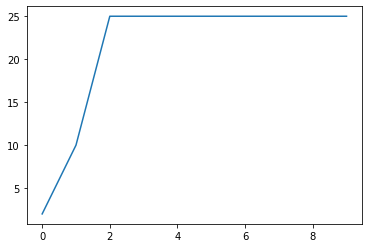

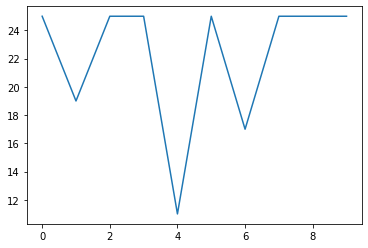

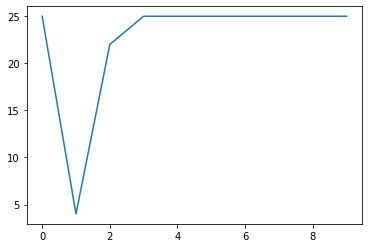

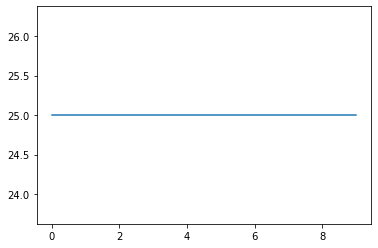

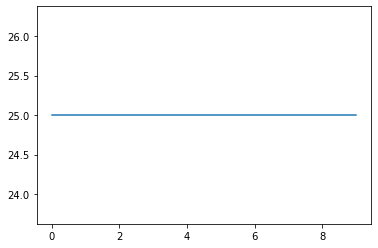

In [41]:
list_source_target = [(0,1),(3,4),(7,12),(0,24),(4,17)]
for iii in list_source_target:
    source = iii[0]
    target = iii[1]
    if source != target :
        iter_ = 10
        iter_actuel = 0
        current_iter = 0
        var_dict = {}
        max_move = 25
        cpt = 0
        bdw = 20

        expirience_replay_used = {}
        expirience_replay = {}
        
        summ = 0
        for ii in range(iter_):
            iter_actuel = ii + 1
            current_node = source
            path = ""
            cpt = 0
            solve_var = []
            j = source

            Used_df = pd.DataFrame(np.zeros((1,1)))
            for link in g.edges:
                s_link = get_tuple_to_name(link)
                Used_df[s_link] = g.edges[link]['used']

            flag_finished = False
            while flag_finished != True and cpt < max_move:
                j = get_action_SARL(current_node,solve_var)
                i = current_node
                #print("current node : {}".format(i))
                #print("action taken : {}".format(j))
                if ((i,j) in get_possible_actions(i)):
                    #print("action taken")
                    #Used_df = new_iter_used(Used_df,j,bdw)
                    path += "{}_".format(str((i,j)))
                    solve_var.append((i,j))
                    var_dict[i,j] = 1
                    cpt = cpt + 1
                    #print(Used_df.head())
                    if g.edges[i,j]['capacity'] > Used_df.iloc[-1,Used_df.columns.get_loc(get_tuple_to_name((i,j)))] + bdw:
                        #print("fail")
                        Used_df = new_iter_used(Used_df,j,bdw)
                        current_node = j
                        if j == target:
                            flag_finished = True
                    else:
                        Used_df = new_iter_used(Used_df,j,0)
            path_ = path[:-1]
            solve_var = get_path_as_list_tuples(path_)

            ## Draw chosen path red ##
            #draw_path(solve_var)
            dict_res[ii]['nodes'] = len(solve_var)
            #print(solve_var)
            SARL_give_final_reward(solve_var,len(solve_var),expirience_replay)
    plot_graph('nodes')
        

In [42]:
### COMPARE ###

In [52]:
def get_action_compare(current_node,solve_var,solution):
    if solution == "SARL":
        inputs = get_state(solve_var) 
        return get_model_SARL_action(current_node,inputs)
    if solution == "MARL":
        list_model = update_list_df(Used_df)

        inputs = list_model[current_node].iloc[-1,:]
        inputs = np.append(inputs,target)
        inputs = np.array(inputs).reshape(1,1, inputs.shape[0])
        expirience_replay[cpt] = inputs
    
        sub_list = get_possible_actions(current_node)
        return get_model_action(current_node,inputs)
    if solution == "RO":
        list_keys = ['shortest_path']
        dict_prob = {}
        dict_prob = dict_prob.fromkeys(list_keys)

        opti_path = {}
        opti_path = dict([(key, []) for key in list_keys])

        target_dict = defaultdict(dict)
        for keys,prob in dict_prob.items():
            prob = pulp.LpProblem("%s" % keys, pulp.LpMinimize)
            var_dict = {}
            for (i, j) in g.edges:
                x = pulp.LpVariable("%s_(%s_%s)" % (keys,i,j), cat=pulp.LpBinary)
                var_dict[i, j] = x
            bdw = 1

            # objective function
            if keys == "shortest_path":
                prob += pulp.lpSum(var_dict[i, j] for i, j in g.edges), "Sum Node Count"

            # constraints
            for node in g.nodes:
                rhs = 0
                if node == current_node:
                    rhs = -1
                elif node == target:
                    rhs = 1
                prob += pulp.lpSum([var_dict[i, k] for i, k in g.edges if k == node]) - pulp.lpSum([var_dict[k, j] for k, j in g.edges if k == node]) == rhs

            # constraints on capacity
            for i,k in g.edges:
                prob += var_dict[i, k]*bdw + Used_df.iloc[-1,Used_df.columns.get_loc(get_tuple_to_name((i,k)))]  <= g.edges[i,k]['capacity']

            # solve
            prob.solve()
            
            solve_var = []
            for i in prob.variables():
                if i.varValue == 1:
                    var = str(i).split('(')
                    var = var[1].split('_')
                    var[0] = int(var[0])
                    var[1] = int(var[1].strip(')'))
                    solve_var.append(tuple(var))

            # print("Number of nodes= {}".format(len(solve_var)))
            
            target_dict[keys]['Number of nodes'] = len(solve_var)
                
            for link in g.edges:
                if var_dict[link].value() == 1.0:
                    #print(link)
                    if link[0] == current_node:
                        return link[1]





In [53]:
list_source_target = [(0,1),(3,4),(7,12),(0,24),(4,17)]
list_solution = ["RO",'MARL','SARL']
for iii in list_source_target:
    source = iii[0]
    target = iii[1]

    print("for source : {} and target : {}".format(source,target))
    for jj in list_solution:
        if source != target :
            iter_ = 1
            iter_actuel = 0
            current_iter = 0
            var_dict = {}
            max_move = 25
            cpt = 0
            bdw = 20

            expirience_replay_used = {}
            expirience_replay = {}
            
            summ = 0
            for ii in range(iter_):
                iter_actuel = ii + 1
                current_node = source
                path = ""
                cpt = 0
                solve_var = []
                j = source

                Used_df = pd.DataFrame(np.zeros((1,1)))
                for link in g.edges:
                    s_link = get_tuple_to_name(link)
                    Used_df[s_link] = g.edges[link]['used']

                flag_finished = False
                while flag_finished != True and cpt < max_move:
                    j = get_action_compare(current_node,solve_var,jj)
                    i = current_node
                    #print("current node : {}".format(i))
                    #print("action taken : {}".format(j))
                    if ((i,j) in get_possible_actions(i)):
                        #print("action taken")
                        #Used_df = new_iter_used(Used_df,j,bdw)
                        path += "{}_".format(str((i,j)))
                        solve_var.append((i,j))
                        var_dict[i,j] = 1
                        cpt = cpt + 1
                        #print(Used_df.head())
                        if g.edges[i,j]['capacity'] > Used_df.iloc[-1,Used_df.columns.get_loc(get_tuple_to_name((i,j)))] + bdw:
                            #print("fail")
                            Used_df = new_iter_used(Used_df,j,bdw)
                            current_node = j
                            if j == target:
                                flag_finished = True
                        else:
                            Used_df = new_iter_used(Used_df,j,0)
                path_ = path[:-1]
                solve_var = get_path_as_list_tuples(path_)

                ## Draw chosen path red ##
                #draw_path(solve_var)
                print("{} : {}".format(jj,len(solve_var)))
    

for source : 0 and target : 1
RO : 2
MARL : 25
SARL : 25
for source : 3 and target : 4
RO : 2
MARL : 25
SARL : 25
for source : 7 and target : 12
RO : 4
MARL : 5
SARL : 25
for source : 0 and target : 24
RO : 3
MARL : 25
SARL : 25
for source : 4 and target : 17
RO : 2
MARL : 25
SARL : 25
